# Permutation testing
Null: there is no relationship between location of flares and the CA minority population ('MINORPOP').
Alt: there is a relationship between flare location and the CA minority population.

Statistic: difference in proportion of MINORPOP within a 5km buffer of any flare versus the MINORPOP proportion outside the flares buffer.

1) Calculate the actual test statistic  
2) Randomize the buffer_present binary variable  
3) Re-calculate proportion of each BG intersecting with a buffer  
5) Calculate the statistics based on the new overlay  
6) Put stats into a new df for storage  
7) visualize the stats with a density plot

In [9]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly
import folium

import numpy as np
import pandas as pd
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

### Read in file, setup

In [3]:
test = pd.read_csv("data/bgformodel_permutation.csv")

In [4]:

in_buffer = np.sum(test['MINORPOP_bg_totprop'] * test['intersect_prop']) / np.sum(test['intersect_prop'])
out_buffer = np.sum(test['MINORPOP_bg_totprop'] * (1 - test['intersect_prop'])) / np.sum(1 - test['intersect_prop'])

# create a table from the in-buffer and outside-buffer proportions
# proportions = pd.concat([in_buffer, out_buffer], axis=1)
# proportions.columns = ['In_Buffer', 'Outside_Buffer']

# table that compares the in-buffer proportions to the outside-buffer proportions
temp = pd.DataFrame({'In_Buffer': [in_buffer], 'Outside_Buffer': [out_buffer]})
print(temp)

             In_Buffer       Outside_Buffer
0                 0.74                 0.60


### Permutation

In [10]:
def get_prop_diff(x):
    in_buffer = np.sum(x['MINORPOP_bg_totprop'] * x['intersect_prop']) / np.sum(x['intersect_prop'])
    out_buffer = np.sum(x['MINORPOP_bg_totprop'] * (1 - x['intersect_prop'])) / np.sum(1 - x['intersect_prop'])
    return(in_buffer - out_buffer)

In [11]:
get_buffer_proportion(test)

0.13491477368362004

### Updated permutation code

/Users/natebender/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/natebender/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.000999000999000999


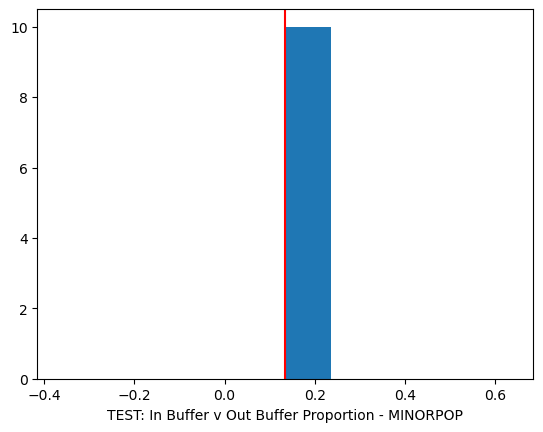

In [14]:
actual_value = get_prop_diff(test)

n_sim = 1000

results = pd.DataFrame({'statistic': [actual_value] + [np.nan] * n_sim})

new_df = test[['MINORPOP_bg_totprop', 'intersect_prop']]

np.random.seed(42)

for i in range(1, n_sim + 1):
    #new_df['buffer_present'] = np.random.choice(new_df['buffer_present'])
    new_df['intersect_prop'] = np.random.choice(new_df['intersect_prop'])
    
    # To do this for real the spatial calculation of proportions will need
    # to be added to this step instead of the random proportion generator
    #new_df['intersect_prop'] = np.where(new_df['buffer_present'] == 0, 0, uniform.rvs(size=len(new_df)))
    
    results.loc[i, 'statistic'] = get_prop_diff(new_df)

pval = np.mean(np.abs(results['statistic']) >= actual_value)
print(pval)

plt.hist(results['statistic'], density=True)
plt.axvline(x=actual_value, color='red')
plt.xlabel('TEST: In Buffer v Out Buffer Proportion - MINORPOP')
plt.ylabel('')
plt.show()

In [19]:
print(f" Proportion of permutation stats equal to or more extreme than actual: {round(np.mean(results['statistic'] >= actual_value),2)}")
print(f" P-value: {round(pval,2)}")

 Proportion of permutation stats equal to or more extreme than actual: 1.0
 P-value: 1.0


## NOTE setup / testing using random numbers and proportions


In [5]:

# # add the column of random proportions to the dataframe
# df['buffer_present'] = np.random.randint(2, size=len(df))
# df['intersect_prop'] = np.random.rand(len(df))
# df.loc[df['buffer_present'] == 0, 'intersect_prop'] = 0
# df['intersect_area'] = df['intersect_prop'] * df['Shape_Area']

In [11]:
# OLD PERMUTATION CODE

# actual_value = get_buffer_proportion(df)

# n_sim = 100

# results = pd.DataFrame({'statistic': np.concatenate(([actual_value], np.full(n_sim, np.nan)))})

# new_df = df[['MINORPOP_bg_totprop', 'intersect_prop', 'buffer_present']].copy()


# for i in range(1, n_sim+1):
#     new_df['buffer_present'] = np.random.randint(2, size=len(df))
#     results.loc[i, 'statistic'] = get_buffer_proportion(new_df)

# pval = (np.abs(results['statistic'] >= actual_value)).mean()

# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.histplot(results['statistic'], kde=True, color='blue', element='step', stat='density')
# plt.axvline(x=actual_value, color='red')
# plt.show()
# print(f' P value is {pval}')
# print(f' Orig diff in proportions is {round(actual_value, 2)}')